In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
# from skimage.util import montage2d as montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight


# montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
# ship_dir = '../input'
# train_image_dir = os.path.join(ship_dir, 'train')

In [33]:
import glob

test_img_dir = 'data/test_img'
inputDF = pd.read_csv('data/train_ship_segmentations_v2.csv')

image_names = [f for f in os.listdir(test_image_dir)]

test_DF = inputDF.loc[inputDF['ImageId'].isin(image_names)]

test_DF.head()

,ImageId,EncodedPixels
217189,f000067f0.jpg,NaN
217190,f00087dcd.jpg,NaN
217191,f000c1a04.jpg,NaN
217192,f00189b8c.jpg,NaN
217193,f001dfbd1.jpg,NaN


In [115]:
len(image_names)

12097

In [116]:
12097/105803

0.11433513227413211

In [110]:
test_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14534 entries, 217189 to 231722
Data columns (total 2 columns):
ImageId          14534 non-null object
EncodedPixels    5150 non-null object
dtypes: object(2)
memory usage: 340.6+ KB


,ImageId,ships,has_ship,has_ship_vec,file_size_kb
3952,f530d9345.jpg,0,0.0,[0.0],190.857422
1873,f2742b996.jpg,2,1.0,[1.0],108.940430
6812,f916f6438.jpg,0,0.0,[0.0],92.360352
10522,fdefaa759.jpg,0,0.0,[0.0],171.391602
5521,f751d8023.jpg,0,0.0,[0.0],128.592773
8846,fbb839c1f.jpg,0,0.0,[0.0],113.283203
10132,fd63cd3ea.jpg,0,0.0,[0.0],136.134766


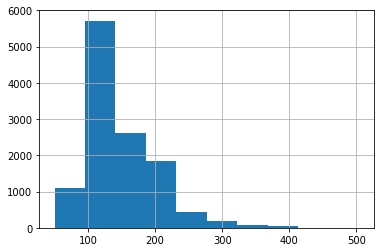

In [36]:
masks = test_DF.copy()
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(test_img_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(7)

In [41]:
############################## Hyperparameters ######################################

BATCH_SIZE = 48
EDGE_CROP = 16
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = (1, 1)
# downsampling in preprocessing
IMG_SCALING = (3, 3)
# number of validation images to use
VALID_IMG_COUNT = 900
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 9
MAX_TRAIN_EPOCHS = 99
AUGMENT_BRIGHTNESS = False


############################## Utility Functions ######################################

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

############################## END ######################################

############################## Generator to produce input ######################################

def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(test_img_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

                



In [43]:
VALID_IMG_COUNT = 900

test_x, test_y = next(make_image_gen(test_DF, VALID_IMG_COUNT))

In [9]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

## intersection over union
def IoU(y_true, y_pred, eps=1e-6):
    if np.max(y_true) == 0.0:
        return IoU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean( (intersection + eps) / (union + eps), axis=0)

Using TensorFlow backend.


In [105]:
# load json and create model
from keras.models import model_from_json
json_file = open('test1/model.json', 'r')
loaded_model_json = json_file.read()
# loaded_model_json
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("test1/seg_model.h5")
print("Loaded model from disk")



Loaded model from disk


In [107]:
loaded_model.compile(optimizer=Adam(1e-3, decay=1e-6), loss=IoU, metrics=['binary_accuracy'])
# pred_y = loaded_model.predict(test_x)


In [53]:
pred_y_int = pred_y.astype(np.uint8)

In [92]:
## intersection over union
def IoU_test(y_true, y_pred, eps=1e-6):
    if np.max(y_true) == 0.0:
        return IoU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
#     intersection = np.sum(y_true * y_pred, axis=1)
#     intersection = np.sum(y_true * y_pred, axis=2)
#     intersection = np.sum(y_true * y_pred, axis=3)
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
#     union = np.sum(y_true, axis=3) + np.sum(y_pred, axis=3) - intersection
    return intersection, union
#     return -K.mean( (intersection) / (union), axis=0)

In [93]:
intersection, union = IoU_test(test_y, pred_y_int, eps=1e-6)

In [77]:
test_y.shape

(900, 256, 256, 1)

In [84]:
intersection

<tf.Tensor 'Sum_12:0' shape=(900,) dtype=uint8>

In [94]:
# Initialize session
import tensorflow as tf
sess = tf.InteractiveSession()

#initialize the variable
init_op = tf.global_variables_initializer()

#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    intersection_list = sess.run(intersection)
    union_list = sess.run(union)
#     print (sess.run(intersection))

In [101]:
eps=1e-6
np.mean((intersection_list+eps) / (union_list+eps), axis=0)

51111.96033448215

In [108]:
score = loaded_model.evaluate(test_x, test_y)

900/900 [==============================] - 441s 490ms/step


In [158]:
print('IoU value is: {}'.format(score[0]))
print('Binary accuracy is: {}'.format(score[1]))

IoU value is: -0.4969383544392056
Binary accuracy is: 0.9867294481065538


In [156]:
inter = np.sum(test_y[4] * pred_y_int[4])
uni = np.sum(test_y[4]) + np.sum(pred_y_int[4]) - inter

(inter + eps) / (uni+eps)

0.8166666668055556

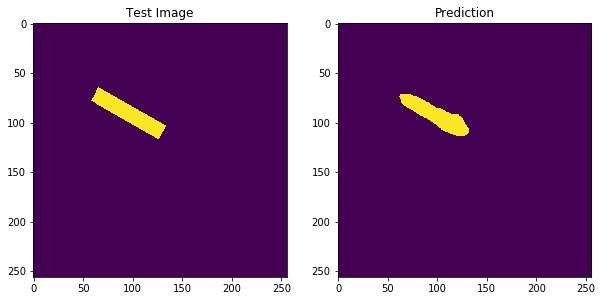

In [152]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
# rle_0 = masks.query('test"')['EncodedPixels']
# img_0 = masks_as_image(rle_0)
ax1.imshow(test_y[4][:,:,0])
ax1.set_title('Test Image')
# rle_1 = multi_rle_encode(img_0)
# img_1 = masks_as_image(rle_1)
ax2.imshow(pred_y_int[4][:,:,0])
ax2.set_title('Prediction')
plt.show()